In [195]:
import nltk, re

sentence = "Amrozi accused his brother,whomhecalled 'the witness', of deliberatelydistorting his evidence."

def get_type_token_ratio(sentence):
  sentence = re.sub(r'[^\w]', ' ', sentence).lower()
  tokens = nltk.word_tokenize(sentence)
  types = nltk.Counter(tokens)
  return (len(types)/len(tokens)) * 100

get_type_token_ratio('Not many people love lions as pets')

100.0

In [ ]:
import jiant.utils.python.io as py_io

MODEL_VAL_NAMES = {
    "bert1": "bert-base",
    "bert2": "bert-large",
    "roberta1": "roberta-base",
    "roberta2": "roberta-large",
    "deberta": "deberta",
}

task_list = ["semgraph2"]

linear_eval_result = {}
for task in task_list:
  task_result = {}
  for model in MODEL_VAL_NAMES:
    model_name = MODEL_VAL_NAMES[model]
    metrics = py_io.read_json(f"./runs/{task}/{model_name}/val_metrics.json")
    metrics_control = py_io.read_json(f"./runs/{task}/{model_name}-control/val_metrics.json")
    accuracy = round(metrics[task]['metrics']['minor']['acc']*100, 3)
    selective = accuracy - round(metrics_control[task]['metrics']['minor']['acc_and_f1_micro']*100, 3)
    task_result[model_name] = {'acc':accuracy, 'sel':selective}
  linear_eval_result[task] = task_result

linear_eval_result

In [ ]:
mlp_eval_result = {}
for task in ["sentiment_vertex"]:
  task_result = {}
  for model in MODEL_VAL_NAMES:
    model_name = MODEL_VAL_NAMES[model]
    metrics = py_io.read_json(f"./runs/{task}/{model_name}-mlp/main/val_metrics.json")
    metrics_control = py_io.read_json(f"./runs/{task}/{model_name}-mlp-control/main/val_metrics.json")
    accuracy = round(metrics[task]['metrics']['minor']['acc_and_f1_micro']*100, 3)
    selective = accuracy - round(metrics_control[task]['metrics']['minor']['acc']*100, 3)
    task_result[model_name] = {'acc':accuracy, 'sel':selective}
  mlp_eval_result[task] = task_result

mlp_eval_result

In [56]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging

predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/structured-prediction-srl-bert.2020.12.15.tar.gz")

def count_freq(pat, txt):
    M = len(pat)
    N = len(txt)
    res = 0
    for i in range(N - M + 1):
        j = 0
        while j < M:
            if (txt[i + j] != pat[j]):
                break
            j += 1
        if (j == M):
            res += 1
            j = 0
    return res

def count_semantic_roles(sentence):
    sem_roles = predictor.predict(sentence=sentence)
    role_count = 0
    for verb in sem_roles['verbs']:
        role_count += count_freq('ARG', verb['description']) + 1
    return role_count

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('stsb-mpnet-base-v2 ')

def semantic_similarity(sentence1, sentence2):
  embeddings1 = model.encode([sentence1], convert_to_tensor=True)
  embeddings2 = model.encode([sentence2], convert_to_tensor=True)
  cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
  return cosine_scores[0][0]

In [ ]:
import torch
import numpy as np

task_name = "semgraph2"
exp_names = ["bert-base", "bert-large", "roberta-base", "roberta-large", "deberta", "bert-base-mlp", "bert-large-mlp", "roberta-base-mlp", "roberta-large-mlp", "deberta-mlp"]
labels = py_io.read_json(f"./analyze/{task_name}/val_labels.json")
val_labels = np.array(labels)
control_labels = py_io.read_json(f"./analyze/{task_name}/control_labels.json")
control_labels = np.array(control_labels)
mean = True

for exp in exp_names:
  val_preds = torch.load(f'runs/{task_name}/{exp}/val_preds.p')
  control_preds = torch.load(f'runs/{task_name}/{exp}-control/val_preds.p')
  preds = val_preds[f'{task_name}']['preds']
  preds_control = control_preds[f'{task_name}']['preds']

  positive = 0
  negative = 0
  positive_con = 0
  negative_con = 0

  for i in range(len(preds)):
      criteria = (preds[i] == val_labels[i]).mean() > 0.5 if mean else (preds[i].tolist() == val_labels[i].tolist())
      if criteria:
        positive += 1
      else:
        negative += 1

  for i in range(len(preds)):
      if (preds_control[i].tolist() == control_labels[i].tolist()):
        positive_con += 1
      else:
        negative_con += 1

  #print(positive)
  #print(negative)
  metrics_control = py_io.read_json(f"./runs/{task_name}/{exp}-control/val_metrics.json")
  accuracy = positive / (positive + negative)
  accuracy = py_io.read_json(f"./runs/{task_name}/{exp}/val_metrics.json")[task_name]['metrics']['minor']['acc']
  control = metrics_control[task_name]['metrics']['minor']['acc_and_f1_micro']
  #positive_con / (positive_con + negative_con)
  #metrics_control[task]['metrics']['minor']['f1_micro']
  print(round(accuracy*100, 3), round((accuracy-control)*100, 3))

monotonicity
contradict_vertex
sentiment_vertex
lexical
anaphora
relational_vertex
semgraph2


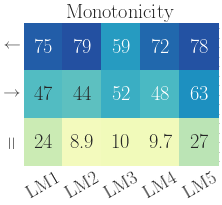

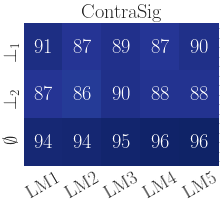

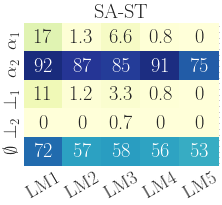

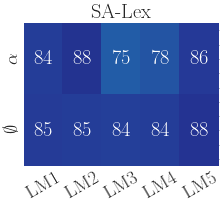

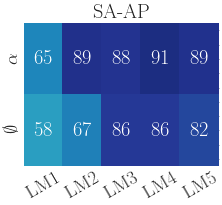

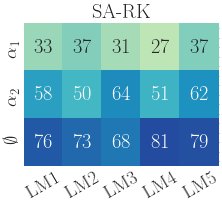

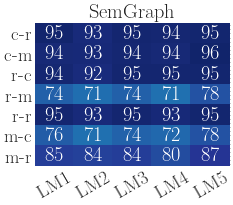

In [42]:
import jiant.utils.python.io as py_io
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
import matplotlib
import seaborn as sn


pparam = dict(xlabel='Models', ylabel='Labels')



task_names = [
    "monotonicity",
    "contradict_vertex",
    "sentiment_vertex",
    "lexical",
    "anaphora",
    "relational_vertex",
    "semgraph2"
]

label_accs = []
for task_name in task_names:
    print(task_name)
    accuracy_log = []
    exp_list = ['bert-base-mlp', 'bert-large-mlp','roberta-base-mlp','roberta-large-mlp','deberta-mlp']
    for exp in exp_list:
        report = py_io.read_json(f'./analyze/{task_name}/preds_log_{exp}.json')
        accuracy_log.append(report['label_acc'])

    label_acc = [0] * len(accuracy_log[0])
    for i in range(len(label_acc)):
        label_acc[i] = [round(acc[i]*100, 2) for acc in accuracy_log]
    label_acc = np.array(label_acc)
    #print(label_acc)
    label_accs.append(label_acc)

models = ['LM1', 'LM2', 'LM3', 'LM4', 'LM5']

labels = {
    "monotonicity": ["↑", "↓", "="],
    "contradict_vertex": ["$\\bot_1$", "$\\bot_2$", "$\\emptyset$"],
    "sentiment_vertex": ["$\\alpha_1$", "$\\alpha_2$", "$\\bot_1$", "$\\bot_2$", "$\\emptyset$"],
    "lexical": ["$\\alpha$", "$\\emptyset$"],
    "anaphora": ["$\\alpha$", "$\\emptyset$"],
    "relational_vertex": ["$\\alpha_1$", "$\\alpha_2$", "$\\emptyset$"],
    "semgraph2": ['c-r','c-m','r-c','r-m','r-r','m-c','m-r']
}

titles = {
    "monotonicity": "Monotonicity",
    "contradict_vertex": "ContraSig",
    "sentiment_vertex": "SA-ST",
    "lexical": "SA-Lex",
    "anaphora": "SA-AP",
    "relational_vertex": "SA-RK",
    "semgraph2": "SemGraph"
}

#sn.set(font_scale=1.7)
with plt.style.context(['science']):
    for i, task_name in enumerate(task_names):
        fig, ax = plt.subplots()
        #cmap = "YlGn"
        cmap = "YlGnBu"
        #cmap = sn.diverging_palette(145, 300, s=60, as_cmap=True)

        ax.set_title(titles[task_name])
        plt.xticks(rotation = 30)
        hm = sn.heatmap(data=label_accs[i], annot=True,
                        cbar=False, cmap=cmap,
                        xticklabels=models,
                        yticklabels=labels[task_name], 
                        ax=ax, vmin=0, vmax=100)
        plt.show()
        fig.savefig(f'./analyze/{task_name}_label.pdf')

In [70]:
import torch
import numpy as np
import jiant.utils.python.io as py_io

model_name = "bert-base-uncased"
task_list = ['monotonicity','anaphora','lexical','sentiment','relational_vertex']
exp_name = ["bert-base-mlp", "bert-large-mlp", "roberta-base-mlp", "roberta-large-mlp", "deberta-mlp"]
task_name = 'sentiment_vertex'

def construct_pos_error_log(task_name, exp_name, mean=True):
  labels = py_io.read_json(f"./analyze/{task_name}/val_labels.json")
  val_labels = np.array(labels)

  val_preds = torch.load(f'runs/{task_name}/{exp_name}/main/val_preds.p')
  preds = val_preds[f'{task_name}']['preds']
  preds_id = val_preds[f'{task_name}']['guids']

  positive = []
  negative = []
  positive_count = [0] * len(val_labels[0])
  negative_count = [0] * len(val_labels[0])

  #print(len(preds_id))
  #print(len(preds))
  #print(len(val_labels))

  for i in range(len(preds_id)):
    sid = int(preds_id[i].split('-')[1]) #.tolist()
    criteria = (preds[i] == val_labels[i]).mean() > 0.8 if mean else (preds[i].tolist() == val_labels[i].tolist())
    if criteria:
      for j in range(len(positive_count)):
        if val_labels[i][j] == 1:
          positive_count[j] += 1
      positive.append(sid)
    else:
      for j in range(len(negative_count)):
        if val_labels[i][j] == 1:
          negative_count[j] += 1
      negative.append(sid)

  print(positive_count)
  print(negative_count)

  #positive_count.remove(0)
  #negative_count.remove(0)

  label_acc = [round(count[0] / (count[0] + count[1]), 3)
                for count in list(zip(positive_count, negative_count))]
  print(label_acc)
  print(len(positive) / (len(positive) + len(negative)))

  report = {
    'negative': negative,
    'positive': positive,
    'label_acc': label_acc,
    'positive_label_count': positive_count,
    'negative_label_count': negative_count,
  }
  py_io.write_json(report, f'./analyze/{task_name}/preds_log_{exp_name}.json')

#for exp in exp_name:
construct_pos_error_log("sentiment_vertex", "bert-large", mean=True)

[63, 1552, 60, 0, 5641]
[4829, 235, 5062, 1212, 4231]
[0.013, 0.868, 0.012, 0.0, 0.571]
0.3196853834389338


In [67]:
import torch
task_name = 'sentiment_vertex'
val_labels = torch.load(f'cache/bert-large-uncased/{task_name}/val_labels/data_00000.chunk').tolist()
for i in range (1,3):
  add_labels = torch.load(f'cache/bert-large-uncased/{task_name}/val_labels/data_0000{i}.chunk').tolist()
  val_labels += add_labels
"""for i in range (10,27):
  add_labels = torch.load(f'cache/bert-large-uncased/{task_name}/val_labels/data_000{i}.chunk').tolist()
  val_labels += add_labels"""
py_io.write_json(val_labels, f"./analyze/{task_name}/val_labels.json")

1
2


In [278]:
import pandas as pd

def generate_num_sem_role_report(task_name, exp_name, num_sem_roles):
  negative = py_io.read_json(f'./analyze/{task_name}/preds_log_{exp}.json')['negative']

  analyzer = {}
  key_align = {}

  for i, num in enumerate(num_sem_roles):
    key_align[i] = num
    analyzer[num] = 0

  for sid in negative:
    num = key_align[sid]
    analyzer[num] += 1

  sem_role_neg = [0] * (1+ (max(num_sem_roles) // 10))

  for num in analyzer:
    for i in range(len(sem_role_neg)):
      if num <= (i+1)*10 and num >= i*10:
        sem_role_neg[i] += analyzer[num]

  report_x = [(i+1)*10 for i in range(len(sem_role_neg))]
  report_y = [ceil(count*100 / len(negative)) for count in sem_role_neg]
  #print(report_x, report_y)
  return report_x, report_y

task_list = ['monotonicity','anaphora','lexical','sentiment','relational_vertex']
exp_name = ["bert-base-mlp", "bert-large-mlp", "roberta-base-mlp", "roberta-large-mlp", "deberta-mlp"]

num_sem_role_report = {}
for exp in exp_name:
  num_sem_role_report[exp] = {}
  for task_name in task_list:
    df = pd.read_json(f'./analyze/{task_name}/val_metric.json').transpose()
    num_sem_roles = list(df['num_sem_role'])
    lex_diversity = list(df['lex_diversity'])
    x, y = generate_num_sem_role_report(task_name, exp, num_sem_roles)
    num_sem_role_report[exp][task_name] = [x,y]

py_io.write_json(num_sem_role_report, './analyze/num_sem_role/report.json')


[10, 20, 30] [89, 13, 2]
[10, 20] [59, 78]
[10, 20, 30, 40] [53, 64, 3, 0]
[10, 20, 30, 40, 50, 60] [1, 21, 64, 19, 5, 0]
[10, 20, 30, 40] [39, 63, 14, 0]
[10, 20, 30] [90, 11, 3]
[10, 20] [46, 80]
[10, 20, 30, 40] [55, 57, 4, 1]
[10, 20, 30, 40, 50, 60] [1, 21, 63, 22, 6, 0]
[10, 20, 30, 40] [39, 62, 14, 1]
[10, 20, 30] [91, 10, 3]
[10, 20] [48, 72]
[10, 20, 30, 40] [57, 60, 2, 0]
[10, 20, 30, 40, 50, 60] [1, 24, 63, 17, 7, 0]
[10, 20, 30, 40] [37, 64, 14, 1]
[10, 20, 30] [92, 10, 2]
[10, 20] [46, 80]
[10, 20, 30, 40] [61, 55, 3, 0]
[10, 20, 30, 40, 50, 60] [1, 22, 62, 21, 7, 1]
[10, 20, 30, 40] [37, 63, 15, 1]
[10, 20, 30] [89, 13, 3]
[10, 20] [47, 79]
[10, 20, 30, 40] [61, 58, 3, 1]
[10, 20, 30, 40, 50, 60] [2, 24, 61, 17, 8, 0]
[10, 20, 30, 40] [38, 63, 14, 1]


<ipython-input-284-3d255bccc6e4>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['10', '$<$10', '$<$20', '$<$30', '$<$40', '$<$50', '$<$60'])


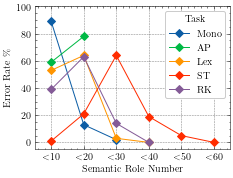

In [284]:

import matplotlib.pyplot as plt
import numpy as np
from math import ceil

pparam = dict(xlabel='Semantic Role Number', ylabel='Error Rate \%')
report = py_io.read_json(f'./analyze/num_sem_role/report.json')['bert-base-mlp']

task_ab = {
    'monotonicity': 'Mono',
    'sentiment': 'ST',
    'anaphora': 'AP',
    'lexical': 'Lex',
    'relational_vertex': 'RK'
}

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    for task in report:
        x = report[task][0]
        y = report[task][1]
        ax.plot(x, y, label=task_ab[task], marker='D')
    ax.legend(title='Task')
    ax.autoscale(tight=True)
    ax.set_xticklabels(['10', '$<$10', '$<$20', '$<$30', '$<$40', '$<$50', '$<$60'])
    ax.set_xlim([5, 65])
    ax.set_ylim([-5, 100])
    ax.set(**pparam)
    fig.savefig('analyze/num_sem_role/num_sem_role.pdf')

In [217]:
import pandas as pd

snli = pd.read_table("./data/benchmark/multinli_1.0_dev_matched.txt")
snli = snli[snli['gold_label'] == 'entailment'].drop(
  ["gold_label",
    "sentence1_binary_parse",
    "sentence2_binary_parse",
    "sentence1_parse",
    "sentence2_parse","promptID","pairID","label1","label2","label3","label4","label5","genre"], axis=1)
snli.head()

,sentence1,sentence2
2,uh i don't know i i have mixed emotions about ...,"I like him for the most part, but would still ..."
13,"You and your friends are not welcome here, sai...",Severn said the people were not welcome there.
15,i'm not sure what the overnight low was,I don't know how cold it got last night.
16,so i have to find a way to supplement that,I need a way to add something extra.
17,the hologram makes up all these things and uh ...,Sometimes it is amusing to see what the hologr...


In [218]:
snli.to_csv("./data/benchmark/mnli_count.csv")

In [221]:
snli1 = snli.iloc[:, 1723:]
snli1.to_csv("./data/benchmark/mnli_count2.csv")